# Library

In [2]:
import pandas as pd
import numpy as np
import numpy.linalg as la
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
random_state = 100


In [4]:
rng = np.random.default_rng(random_state)


# Import data & Preprocess

In [5]:
x_read = pd.read_csv("./exercise.csv")
y_read = pd.read_csv("./calories.csv")

x_read = x_read.drop(columns=["User_ID"])
y_read = y_read.drop(columns=["User_ID"])


### Frequency encoding to gender

In [6]:
count = x_read.value_counts("Gender")
x_read["Gender"] = x_read["Gender"].map(count / sum(count))
x_read.head()


,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,0.496467,68,190.0,94.0,29.0,105.0,40.8
1,0.503533,20,166.0,60.0,14.0,94.0,40.3
2,0.496467,69,179.0,79.0,5.0,88.0,38.7
3,0.503533,34,179.0,71.0,13.0,100.0,40.5
4,0.503533,27,154.0,58.0,10.0,81.0,39.8


### Split data

In [7]:
def random_split(x, y):
    assert len(x) == len(y)
    idx_rng = rng.permutation(len(x))

    x_rng = x.iloc[idx_rng]
    y_rng = y.iloc[idx_rng]

    train_split = int(0.7 * len(x))
    validate_split = int(0.8 * len(x))

    x_train, x_validate, x_test = np.split(x_rng, [train_split, validate_split])
    y_train, y_validate, y_test = np.split(y_rng, [train_split, validate_split])
    return x_train, x_validate, x_test, y_train, y_validate, y_test


x_train, x_validate, x_test, y_train, y_validate, y_test = random_split(
    x_read, y_read
)


In [8]:
class CalDataset:
    def __init__(self) -> None:
        feature = pd.read_csv("./exercise.csv")
        label = pd.read_csv("./calories.csv")

        feature = feature.drop("User_ID", axis=1)
        label = label.drop("User_ID", axis=1)

        feature["Gender"] = feature["Gender"].map({"male": 1, "female": 0})

        self.header = feature.columns

        self.data = pd.concat((feature, label), axis=1).to_numpy()

    def random_split(self):
        rng_data = rng.permutation(self.data)

        train_split = int(np.floor(0.7 * self.__len__()))
        validate_split = int(np.floor(0.8 * self.__len__()))

        return (
            rng_data[:train_split],
            rng_data[train_split:validate_split],
            rng_data[validate_split:],
        )

    def __getitem__(self, index: int):
        return self.data[index]

    def __len__(self):
        return len(self.data)

    def getHeader(self):
        return self.header


In [9]:
data = CalDataset()
train_data, validate_data, test_data = data.random_split()


# Basis function

In [10]:
def identity_basis_function(x):
    return x


def gaussian_basis_function(x, mu, sigma):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma**2)


def polynomial_basis_function(x, power):
    return x**power


def expand(x):
    return np.concatenate([np.ones((x.shape[0], 1)), x], axis=1)


def get_identity_matrix(x):
    return expand(identity_basis_function(x))


def cal_pairwise_dis(x):
    x_cross = x @ x.T
    x_norm = np.repeat(np.diag(x_cross).reshape([1, -1]), x.shape[0], axis=0)
    return np.median(x_norm + x_norm.T - 2 * x_cross)


def get_gaussian_matrix(x):
    # Using standard deviation as sigma
    std = cal_pairwise_dis(x)

    x_maxs = np.max(x, axis=0)
    x_mins = np.min(x, axis=0)

    centroids = np.linspace(x_maxs, x_mins, 50, axis=0)

    # For each mu, calculate basis function of all data
    phi = [gaussian_basis_function(x, centroid, std) for centroid in centroids]
    phi = np.concatenate(phi, axis=1)

    return expand(phi)


def normalize(x):
    x_maxs = np.max(x, axis=0)
    x_mins = np.min(x, axis=0)

    return (x - x_mins) / (x_maxs - x_mins)


# MLR

In [11]:
def MLR(x_train, y_train, x_test, lamda):
    x_basisMatrix = get_gaussian_matrix(x_train)
    weight = (
        la.inv(
            x_basisMatrix.T @ x_basisMatrix
            + lamda * np.identity(x_basisMatrix.shape[1])
        )
        @ x_basisMatrix.T
        @ y_train
    )

    y_basisMatrix = get_gaussian_matrix(x_test)
    return y_basisMatrix @ weight


In [12]:
def calMSE(predict: np.ndarray, actual: np.ndarray):
    return np.mean((predict - actual) ** 2)


In [13]:
x_train = train_data[:, :-1]
y_train = train_data[:, -1][:, np.newaxis]
x_test = test_data[:, :-1]
y_test = test_data[:, -1][:, np.newaxis]
x_validate = validate_data[:, :-1]
y_validate = validate_data[:, -1][:, np.newaxis]

y_pred = MLR(normalize(x_train), y_train, normalize(x_test), 0.1)
print(calMSE(y_pred, y_test))


137.32633514819102


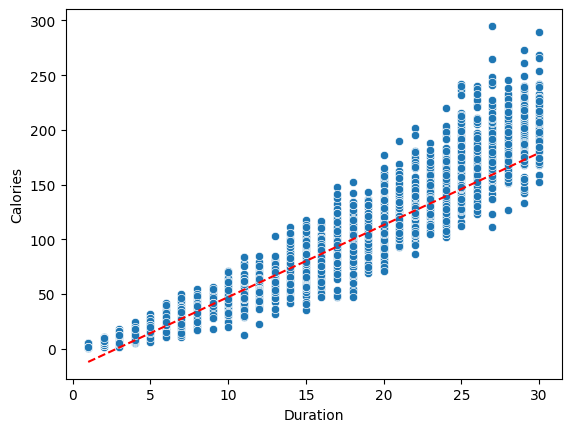

In [14]:
def plot_OLS(x_test, y_pred):
    x = np.linspace(x_test[:, 4].min(), x_test[:, 4].max(), 100)
    m, n = np.polyfit(x_test[:, 4], y_pred, 1)
    plt.plot(x, m * x + n, c="r", ls="dashed")


def plot_truth():
    df = pd.DataFrame(x_test[:, 4], columns=["Duration"])
    df.loc[:, "Calories"] = y_test
    sns.scatterplot(df, x="Duration", y="Calories")


plot_truth()
plot_OLS(x_test, y_pred)


# BLR

In [15]:
def posterior(phi, t, alpha, beta, return_inverse=False):
    S_N_inv = alpha * np.eye(phi.shape[1]) + beta * phi.T.dot(phi)
    S_N = la.inv(S_N_inv)
    m_N = beta * S_N.dot(phi.T).dot(t)

    return (m_N, S_N) if not return_inverse else (m_N, S_N, S_N_inv)


def posterior_predictive(phi_test, m_N, S_N, beta):
    y = phi_test @ m_N
    y_var = 1 / beta + np.sum(phi_test.dot(S_N) * phi_test, axis=1)

    return y, y_var


In [16]:
def log_marginal_likelihood(phi, t, alpha, beta):
    """Computes the log of the marginal likelihood."""
    N, M = phi.shape

    m_N, _, S_N_inv = posterior(phi, t, alpha, beta, return_inverse=True)

    E_D = beta * np.sum((t - phi @ m_N) ** 2)
    E_W = alpha * np.sum(m_N**2)

    score = (
        M * np.log(alpha)
        + N * np.log(beta)
        - E_D
        - E_W
        - np.log(np.linalg.det(S_N_inv))
        - N * np.log(2 * np.pi)
    )

    return 0.5 * score


def fit(phi, t, alpha_0=1e-5, beta_0=1e-5, max_iter=200, rtol=1e-5):
    """
    Jointly infers the posterior sufficient statistics and optimal values
    for alpha and beta by maximizing the log marginal likelihood.

    Args:
        Phi: Design matrix (N x M).
        t: Target value array (N x 1).
        alpha_0: Initial value for alpha.
        beta_0: Initial value for beta.
        max_iter: Maximum number of iterations.
        rtol: Convergence criterion.

    Returns:
        alpha, beta, posterior mean, posterior covariance.
    """

    N, M = phi.shape

    eigenvalues_0 = la.eigvalsh(phi.T.dot(phi))

    beta = beta_0
    alpha = alpha_0

    for i in range(max_iter):
        beta_prev = beta
        alpha_prev = alpha

        eigenvalues = eigenvalues_0 * beta

        m_N, S_N, S_N_inv = posterior(phi, t, alpha, beta, return_inverse=True)

        gamma = np.sum(eigenvalues / (eigenvalues + alpha))
        alpha = gamma / np.sum(m_N**2)

        beta_inv = 1 / (N - gamma) * np.sum((t - phi.dot(m_N)) ** 2)
        beta = 1 / beta_inv

        if np.isclose(alpha_prev, alpha, rtol=rtol) and np.isclose(
            beta_prev, beta, rtol=rtol
        ):
            print(f"Convergence after {i + 1} iterations.")
            return alpha, beta, m_N, S_N

    print(f"Stopped after {max_iter} iterations.")
    return alpha, beta, m_N, S_N


In [17]:
phi_train = get_gaussian_matrix(x_train)
phi_test = get_gaussian_matrix(x_validate)

# m_N, S_N = posterior(phi_train, y_train, alpha, beta)
alpha, beta, m_N, S_N = fit(phi_train, y_train)
y, y_var = posterior_predictive(phi_test, m_N, S_N, beta)

calMSE(y, y_validate)


Convergence after 10 iterations.


98.40094476129

In [18]:
def plot_sample(x_test, y_sample):
    for one in y_sample.T:
        plot_OLS(x_test, one)


def plot_predictive(x_test, y, y_std):
    plot_OLS(x_test, y)
    plt.fill_between(
        x_test[:, 4], y.ravel() - y_std, y.ravel() + y_std, alpha=0.2
    )


<Axes: xlabel='Duration', ylabel='Calories'>

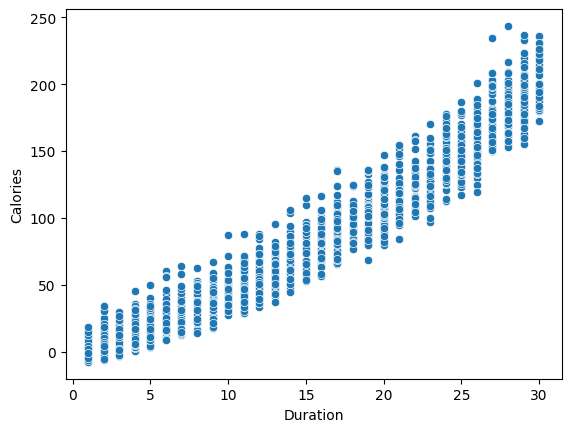

In [19]:
df = pd.DataFrame(x_validate[:, 4], columns=["Duration"])
df.loc[:, "Calories"] = y
sns.scatterplot(df, x="Duration", y="Calories")


# Other regression model

## Random forest

In [22]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(x_train, y_train.ravel())

y_pred = rf.predict(x_test)


7769.431111388889

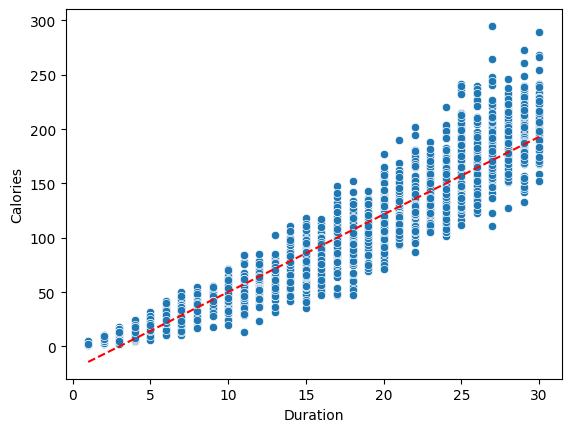

In [23]:
plot_truth()
plot_OLS(x_test, y_pred)
calMSE(y_pred, y_test)
